In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

import xgboost as xgb

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('criminal_train.csv')
test = pd.read_csv('criminal_test.csv')

In [3]:
features = [i for i in test.columns if i not in ['PERID']]

In [6]:
def modelfit(model, train_data, train_label, predictors, eval_metric, useTrainCV=True, cv_folds=10, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        params = {
            'objective' : xgb_param['objective'],
            'base_score' : xgb_param['base_score'],
            'colsample_bylevel' : xgb_param['colsample_bylevel'],
            'colsample_bytree' : xgb_param['colsample_bytree'],
            'gamma' : xgb_param['gamma'],
            'eta' : xgb_param['learning_rate'],
            'max_delta_step' : xgb_param['max_delta_step'],
            'max_depth' : xgb_param['max_depth'],
            'min_child_weight' : xgb_param['min_child_weight'],
            'alpha' : xgb_param['reg_alpha'],
            'lambda': xgb_param['reg_lambda'],
            'scale_pos_weight' : xgb_param['scale_pos_weight'],
            'subsample' : xgb_param['subsample'],     
        }
        dtrain = xgb.DMatrix(data=train_data[predictors], label=train_label)
        cvresult = xgb.cv(params , dtrain, num_boost_round=model.get_params()['n_estimators'], stratified=True, nfold=cv_folds, metrics=eval_metric, early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        # print(cvresult)
        print("########### n_estimators = %f" % cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(train_data[predictors], train_label,eval_metric=eval_metric)
        
    # Predict training set:
    train_predictions = model.predict(train_data[predictors])
    train_predprob = model.predict_proba(train_data[predictors])[:,1]
    
    # Predict X_valid set:
    #valid_predictions = model.predict(X_valid[predictors])
    #valid_predprob = model.predict_proba(X_valid[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("Accuracy score (Train): %.5g" % accuracy_score(train_label, train_predictions))
    print("matthews corr coef (Train): %.5g" % matthews_corrcoef(train_label, train_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(train_label, train_predprob))
    print("precision score (Train): %.5g" % precision_score(train_label, train_predictions, average='micro'))
    print("RECALL score (Train): %f" % recall_score(train_label, train_predictions, average='micro'))
    print("Confusion matrix (Train):\n")
    con_mat = confusion_matrix(train_label, train_predictions)    
    print(con_mat)
    print("true predictions {0}".format(con_mat[0][0] + con_mat[1][1]))
    # print("AUC Score (Validation): %f" % roc_auc_score(y_valid, valid_predprob))
    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return model

In [8]:
clf1 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, scale_pos_weight=(42543/3175))

########### n_estimators = 87.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.89597
AUC Score (Train): 0.975171
precision score (Train): 0.89597
RECALL score (Train): 0.895971
Confusion matrix (Train):

[[37857  4686]
 [   70  3105]]


<IPython.core.display.Javascript object>


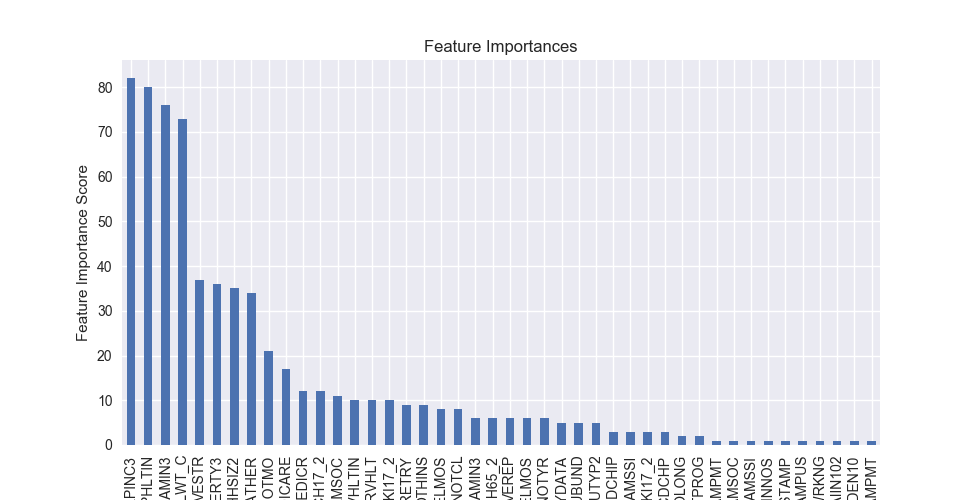

In [24]:
clf1 = modelfit(clf1, train, train['Criminal'], features, 'auc')

In [33]:
print("true zeroes + ones {0}".format(37857+3105))
print("precision score {0}".format((37857+3105)/(37857+70+3105+4686)))

true zeroes + ones 40962
precision score 0.8959709523601207


### PLB = 0.80267

In [11]:
clf2 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, max_delta_step=1)  

########### n_estimators = 234.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95575
AUC Score (Train): 0.977073
precision score (Train): 0.95575
RECALL score (Train): 0.955750
Confusion matrix (Train):

[[41817   726]
 [ 1297  1878]]


<IPython.core.display.Javascript object>


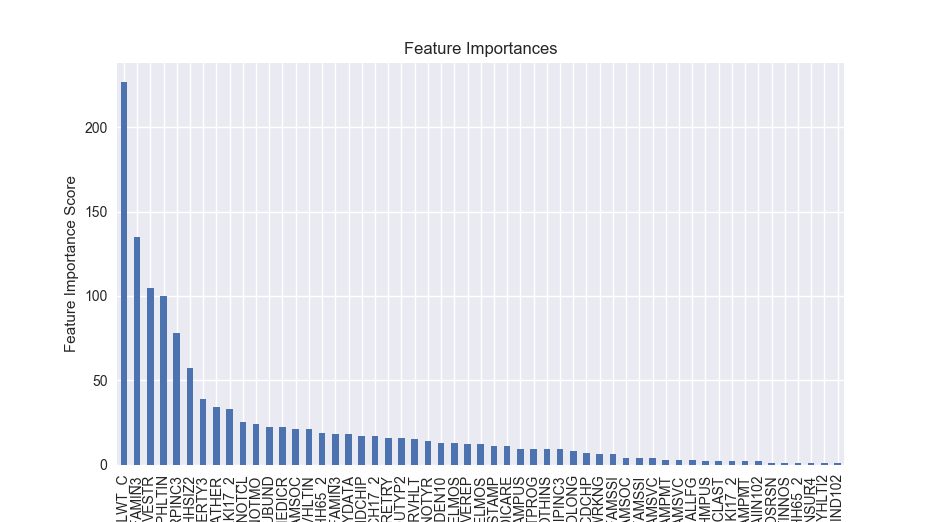

In [25]:
clf2 = modelfit(clf2, train, train['Criminal'], features, 'logloss')

In [34]:
print("true zeroes + ones {0}".format(41817+1878))
print("precision score {0}".format((41817+1878)/(41817+1297+1878+726)))

true zeroes + ones 43695
precision score 0.9557504702742902


In [14]:
pred1 = clf2.predict(test[features])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
pd.Series(pred1).value_counts()

0    10790
1      640
dtype: int64

In [13]:
sub = pd.DataFrame(columns = ['PERID', 'Criminal'])

In [15]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred1

In [17]:
sub.to_csv('xgb_lolo.csv', index=False, encoding='utf-8')

### PLB :0.80389

In [18]:
clf3 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, max_delta_step=5)  

########### n_estimators = 156.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95431
AUC Score (Train): 0.975503
precision score (Train): 0.95431
RECALL score (Train): 0.954307
Confusion matrix (Train):

[[41820   723]
 [ 1366  1809]]


<IPython.core.display.Javascript object>


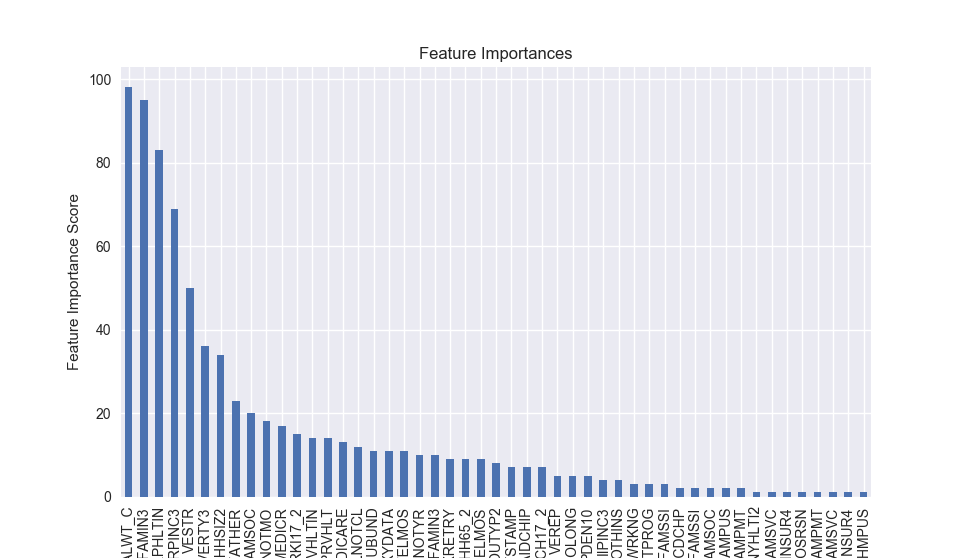

In [28]:
clf3 = modelfit(clf3, train, train['Criminal'], features, 'logloss')

In [35]:
print("true zeroes + ones {0}".format(41820+1809))
print("precision score {0}".format((41820+1809)/(1809+41820+723+1366)))

true zeroes + ones 43629
precision score 0.9543068375694475


In [29]:
pred3 = clf3.predict(test[features])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
pd.Series(pred3).value_counts()

0    10804
1      626
dtype: int64

In [30]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred3

In [31]:
sub.to_csv('xgb_lolo1.csv', index=False, encoding='utf-8')

#### max_delta_step=10 and max_delta_step=5  gave same results 

In [36]:
clf4 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, max_delta_step=10)  

########### n_estimators = 156.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95431
AUC Score (Train): 0.975503
precision score (Train): 0.95431
RECALL score (Train): 0.954307
Confusion matrix (Train):

[[41820   723]
 [ 1366  1809]]


<IPython.core.display.Javascript object>


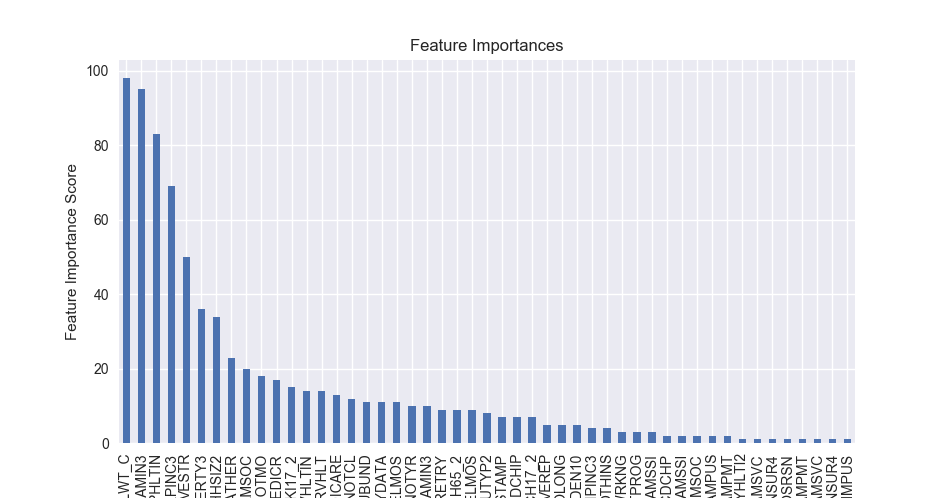

In [37]:
clf4 = modelfit(clf4, train, train['Criminal'], features, 'logloss')

### PLB : 0.82123

In [41]:
clf5 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0, max_delta_step=5, scale_pos_weight=(5))  

########### n_estimators = 1647.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95881
AUC Score (Train): 0.991024
precision score (Train): 0.95881
RECALL score (Train): 0.958813
Confusion matrix (Train):

[[40767  1776]
 [  107  3068]]


<IPython.core.display.Javascript object>


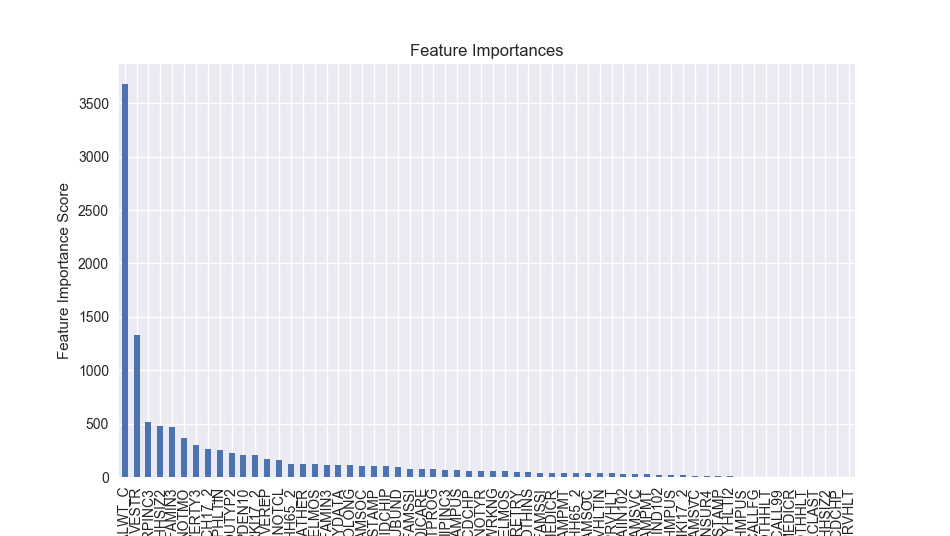

In [42]:
clf5 = modelfit(clf5, train, train['Criminal'], features, 'logloss')

In [45]:
print("true zeroes + ones {0}".format(40767+3068))
print("precision score {0}".format((40767+3068)/(3068+40767+107+1776)))

true zeroes + ones 43835
precision score 0.9588127214663809


In [43]:
pred5 = clf5.predict(test[features])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
pd.Series(pred5).value_counts()

0    10191
1     1239
dtype: int64

In [44]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred5
sub.to_csv('submissions/sub_xgb1.csv', index=False, encoding='utf-8')

### PLB : 0.83869 

In [7]:
clf6 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=1, min_child_weight= 3, reg_alpha=2, max_delta_step=4, scale_pos_weight=(3))  

########### n_estimators = 389.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.94842
matthews corr coef (Train): 0.68784
AUC Score (Train): 0.979549
precision score (Train): 0.94842
RECALL score (Train): 0.948423
Confusion matrix (Train):

[[40612  1931]
 [  427  2748]]
true predictions 43360


<IPython.core.display.Javascript object>


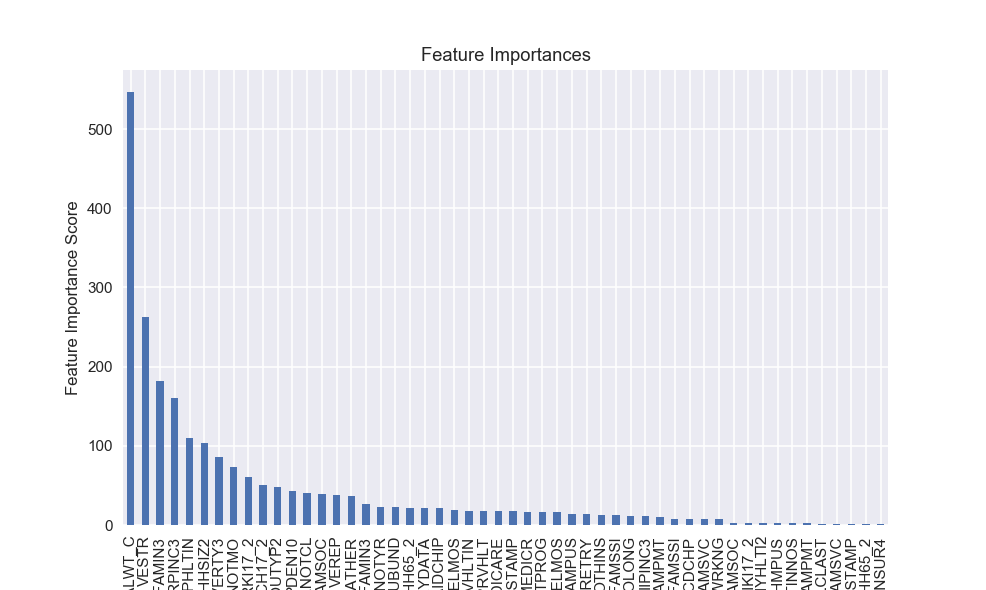

In [8]:
clf6 = modelfit(clf6, train, train['Criminal'], features, 'logloss')

In [9]:
train.shape

(45718, 72)

In [10]:
(43360/45718) * 100

94.84229406360734

In [57]:
print("true zeroes + ones {0}".format(40612+2748))
print("precision score {0}".format((40612+2748)/(2748+40612+427+1931)))

true zeroes + ones 43360
precision score 0.9484229406360734


In [49]:
pred6 = clf6.predict(test[features])
pd.Series(pred6).value_counts()

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    10236
1     1194
dtype: int64

In [50]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred6
sub.to_csv('submissions/sub_xgb2.csv', index=False, encoding='utf-8')

### PLB :  0.80536

In [54]:
clf7 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, gamma=1, min_child_weight= 3, reg_alpha=2, max_delta_step=4, scale_pos_weight=1)  

########### n_estimators = 240.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95595
AUC Score (Train): 0.976725
precision score (Train): 0.95595
RECALL score (Train): 0.955947
Confusion matrix (Train):

[[41806   737]
 [ 1277  1898]]


<IPython.core.display.Javascript object>


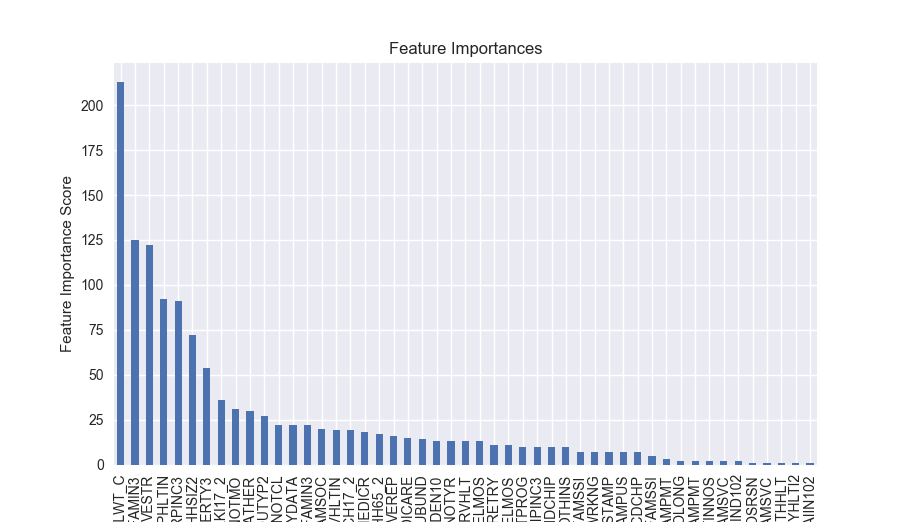

In [55]:
clf7 = modelfit(clf7, train, train['Criminal'], features, 'logloss')

In [56]:
print("true zeroes + ones {0}".format(41806+1898))
print("precision score {0}".format((41806+1898)/(1898+41806+737+1277)))

true zeroes + ones 43704
precision score 0.955947329279496


In [58]:
pred7 = clf7.predict(test[features])
print(pd.Series(pred7).value_counts())

0    10782
1      648
dtype: int64


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred7
sub.to_csv('submissions/sub_xgb3.csv', index=False, encoding='utf-8')

### PLB : 0.79969

In [60]:
clf8 = xgb.XGBClassifier(objective='reg:logistic')

########### n_estimators = 100.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95334
AUC Score (Train): 0.973225
precision score (Train): 0.95334
RECALL score (Train): 0.953344
Confusion matrix (Train):

[[41807   736]
 [ 1397  1778]]


<IPython.core.display.Javascript object>


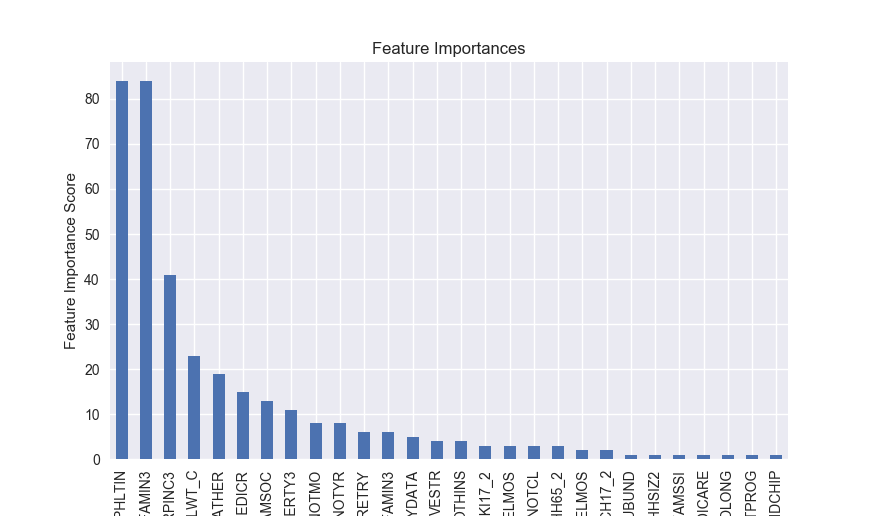

In [61]:
clf8 = modelfit(clf8, train, train['Criminal'], features, 'logloss')

In [63]:
print("true zeroes + ones {0}".format(41807+1778))

true zeroes + ones 43585


In [64]:
pred8 = clf8.predict(test[features])
print(pd.Series(pred8).value_counts())

0    10808
1      622
dtype: int64


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [65]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred8
sub.to_csv('submissions/sub_xgb4.csv', index=False, encoding='utf-8')

In [67]:
clf8.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'objective': 'reg:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

In [71]:
from sklearn.linear_model import SGDClassifier

In [79]:
sgd_clf1 = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, n_iter  = 1000 )

In [80]:
sgd_clf1.fit(train[features], train['Criminal'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [81]:
precision_score(train['Criminal'], sgd_clf1.predict(train[features]), average = 'micro')

0.9305525176079443

##  PLB : 0.83239

In [11]:
clf9 = xgb.XGBClassifier(objective ='reg:logistic',learning_rate=0.1, max_depth=3, n_estimators=3000, subsample=0.8, colsample_bytree=0.8, gamma=1, min_child_weight= 4, reg_alpha=2, reg_lambda=2, max_delta_step=5, scale_pos_weight=(4))  

########### n_estimators = 958.000000


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy score (Train): 0.95162
matthews corr coef (Train): 0.71937
AUC Score (Train): 0.984698
precision score (Train): 0.95162
RECALL score (Train): 0.951616
Confusion matrix (Train):

[[40587  1956]
 [  256  2919]]
true predictions 43506


<IPython.core.display.Javascript object>


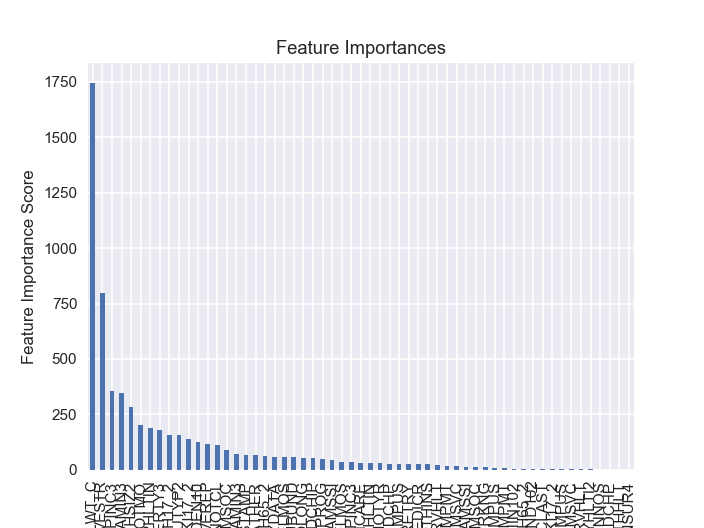

In [12]:
clf9 = modelfit(clf9, train, train['Criminal'], features, 'logloss')

In [14]:
pred9 = clf9.predict(test[features])
pd.Series(pred9).value_counts()

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    10183
1     1247
dtype: int64

In [15]:
sub['PERID'] = test['PERID']
sub['Criminal'] = pred9
sub.to_csv('submissions/sub_xgb5.csv', index=False, encoding='utf-8')

# # # # # # # # # # # # # # # # # # # # # # # # # # # #  

In [4]:
from sklearn.linear_model import SGDClassifier

In [102]:
sgdclf1 = SGDClassifier()

In [105]:
sgdclf1.fit(train[features], train['Criminal'], cla)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [106]:
sgdclf1.predict(test[features]).sum()

0

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [101]:
from sklearn.svm import LinearSVC

In [107]:
svcclf = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight="balanced", verbose=0, random_state=2018, max_iter=2000)  

In [110]:
svcclf.fit(train[features], train['Criminal'])

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=2018, tol=0.0001,
     verbose=0)

In [112]:
svcclf.predict(test[features]).sum()

7

## # # # # # # # # # # # # # # # # # # # # 

In [113]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lrclf1 = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)  